# import

In [1]:
import pandas as pd
import numpy as np
from itertools import product

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# graph
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

#모델 저장
import pickle
import joblib

# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

데이터 구성: 중고차 데이터 
- price: 목표변수, 중고차의 가격 단위(1000원)
- Name : 자동차 브랜드와 이름
- Location : 자동차를 팔거나 구매할 수 있는 위치
- Year : 모델 년도 혹은 버전
- Kilometers_Driven : 이전 소유주의 차량 주행거리(km)
- Fuel_Type : 자동차의 사용연료 종류
- Transmission : 사용 변속기 종류
- Owner_Type : 직접소유, 중고소유 여부
- Mileage : 자동차 회사가 제공하는 표준주행거리(kmpl) - 리터당 가는거리 - 연비
- Engine : 엔진의 배기량(cc) 
- Power : 엔진의 최대출력 (bhp) 
- Seats : 차의 좌석 수
- New_Price : 뉴 모델(신차)의 가격

In [2]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/Car.csv", encoding='euc-kr')
raw_data.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'Kilometers_Driven'}>,
        <Axes: title={'center': 'Seats'}>]], dtype=object)

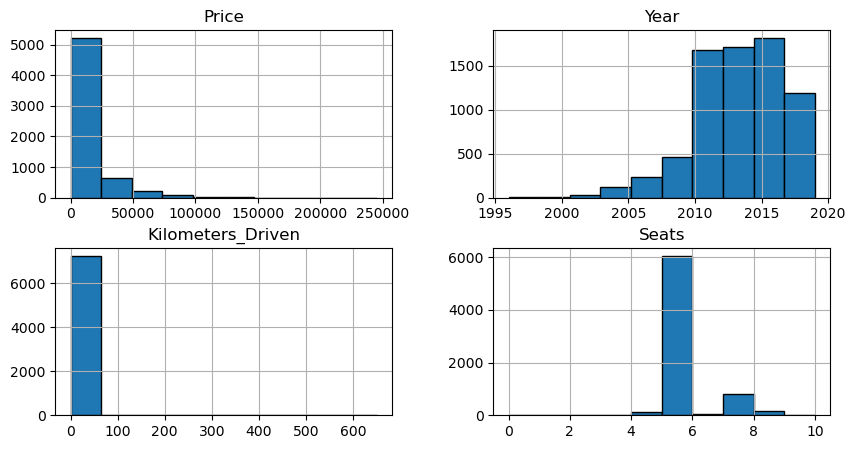

In [3]:
for_graph = raw_data.select_dtypes(exclude='object')
for_graph['Kilometers_Driven'] = for_graph['Kilometers_Driven']/10000
for_graph.hist(figsize=(10, 5), edgecolor='black')

In [4]:
raw_data.describe()

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


# 1. 결측치, 이상치 확인 및 drop, 행제거

In [5]:
raw_data.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

### 결측치

In [6]:
mv_data = raw_data.drop(['New_Price', 'Engine'], axis = 1) # 결측치가 6247개인 New_Price 제거, Engine(다중공선성 문제 해결)
mv_data.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,58.16 bhp,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,126.2 bhp,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,88.7 bhp,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,88.76 bhp,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,140.8 bhp,5.0


In [7]:
print(f"결측치가 하나라도 존재하는 행: {mv_data.isnull().any(axis=1).sum()}개")

결측치가 하나라도 존재하는 행: 1097개


In [8]:
mv_data_1 = mv_data.dropna(subset = ['Price']) #price 행의 결측치 제거 - y 변수이기 때문에 건드릴 수 없음
print(f'제거한 행 갯수:{len(mv_data) - len(mv_data_1)}')
mv_data_1.info()

제거한 행 갯수:1053
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 7236
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6200 non-null   object 
 1   Location           6200 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               6200 non-null   int64  
 4   Kilometers_Driven  6200 non-null   int64  
 5   Fuel_Type          6200 non-null   object 
 6   Transmission       6200 non-null   object 
 7   Owner_Type         6200 non-null   object 
 8   Mileage            6198 non-null   object 
 9   Power              6164 non-null   object 
 10  Seats              6158 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 581.2+ KB


In [9]:
# Mileage, Power, Seats 결측치 제거

mv_data_2 = mv_data_1.copy()
mv_data_2[['Mileage','Unit']] = mv_data_2['Mileage'].str.split(" ", expand=True)
mv_data_2.drop('Unit', axis = 1, inplace = True)
mv_data_2[['Power','Unit']] = mv_data_2['Power'].str.split(" ", expand=True)
mv_data_2.drop('Unit', axis = 1,inplace = True)

mv_data_2['Mileage'] = mv_data_2['Mileage'].astype(float)
mv_data_2['Power'] = mv_data_2['Power'].replace('null', np.nan).astype(float) # null(str)이 들어간 행 제거
#mv_data_2[mv_data_2['Name'].str.startswith('Porsche')]
mv_data_2 = mv_data_2.dropna(subset = ['Mileage', 'Power', 'Seats']) #price 행만 제거
print(f'제거한 행 갯수:{len(mv_data_1) - len(mv_data_2)}')
mv_data_2.info()

제거한 행 갯수:147
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   float64
 9   Power              6053 non-null   float64
 10  Seats              6053 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 567.5+ KB


In [10]:
mv_data_2.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Power                0
Seats                0
dtype: int64

### 이상치

In [11]:
category_columns = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Power', 'Seats']

# 각 열에 대한 value_counts를 구하고, 그 결과를 concat으로 합침
count_v_df = pd.DataFrame()

for col in category_columns:
    temp = mv_data_2[col].value_counts().sort_values(ascending=False)  # 빈도수 기준으로 내림차순 정렬
    temp_df = pd.DataFrame({col + '_Value': temp.index, col + '_Count': temp.values})
    count_v_df = pd.concat([count_v_df, temp_df], axis=1)

# 결과를 CSV로 저장
count_v_df.to_csv("./value_counts.csv", index=False)

# 결과 일부 확인
count_v_df.head(10)

,Location_Value,Location_Count,Fuel_Type_Value,Fuel_Type_Count,Transmission_Value,Transmission_Count,Owner_Type_Value,Owner_Type_Count,Mileage_Value,Mileage_Count,Power_Value,Power_Count,Seats_Value,Seats_Count
0,Mumbai,802.0,Diesel,3248.0,Manual,4287.0,First,5005.0,18.90,175,74.00,239.0,5.0,5069.0
1,Hyderabad,735.0,Petrol,2739.0,Automatic,1766.0,Second,940.0,17.00,152,98.60,136.0,7.0,696.0
2,Kochi,670.0,CNG,56.0,NaN,NaN,Third,101.0,18.60,121,73.90,125.0,8.0,135.0
3,Coimbatore,657.0,LPG,10.0,NaN,NaN,Fourth & Above,7.0,20.36,88,140.00,123.0,4.0,102.0
4,Pune,604.0,NaN,NaN,NaN,NaN,NaN,NaN,21.10,87,88.50,120.0,6.0,30.0
5,Delhi,563.0,NaN,NaN,NaN,NaN,NaN,NaN,16.00,78,67.04,115.0,2.0,14.0
6,Kolkata,538.0,NaN,NaN,NaN,NaN,NaN,NaN,18.50,71,67.10,113.0,10.0,4.0
7,Chennai,488.0,NaN,NaN,NaN,NaN,NaN,NaN,15.10,71,78.90,111.0,9.0,3.0
8,Jaipur,413.0,NaN,NaN,NaN,NaN,NaN,NaN,20.00,71,82.00,102.0,NaN,NaN
9,Bangalore,354.0,NaN,NaN,NaN,NaN,NaN,NaN,12.80,70,117.30,97.0,NaN,NaN


##### Fuel_Type

In [12]:
mv_data_2['Fuel_Type'].value_counts()

Diesel    3248
Petrol    2739
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

In [13]:
# Fuel_Type 경유와 휘발유만 남기기
fuel_outlier_index = mv_data_2[mv_data_2['Fuel_Type'].isin(['CNG','LPG'])].index
outlier_process_f = mv_data_2.drop(fuel_outlier_index)
outlier_process_f['Fuel_Type'].value_counts()

Diesel    3248
Petrol    2739
Name: Fuel_Type, dtype: int64

In [14]:
outlier_process_f['Owner_Type'].value_counts()

First             4951
Second             928
Third              101
Fourth & Above       7
Name: Owner_Type, dtype: int64

##### Owner_Type

In [15]:
# Owner_Type 4번째 이상 날리기
OT_outlier_index = outlier_process_f[outlier_process_f['Owner_Type'] == 'Fourth & Above'].index
outlier_process_O = outlier_process_f.drop(OT_outlier_index)
outlier_process_O['Owner_Type'].value_counts()

# 숫자로 변환
outlier_process_O['Owner_Type'] = outlier_process_O['Owner_Type'].map({'First':1,'Second':2,'Third':3})
outlier_process_O.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,1,19.67,126.20,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,1,18.20,88.70,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,1,20.77,88.76,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,2,15.20,140.80,5.0
6,Nissan Micra Diesel XV,Jaipur,5365.36,2013,86999,Diesel,Manual,1,23.08,63.10,5.0


##### Seats

In [16]:
# Seats
# 조건에 따라 값 변경
def car_categorize(value):
    if 2 <= value <= 4:
        return 'small'
    elif value == 5:
        return 'medium'
    elif 6 <= value <= 7:
        return 'large'
    else:
        return 'x_large'  # 범위 밖의 값에 대해

outlier_process_O['Seats'].value_counts()
outlier_process_S = outlier_process_O.copy()

outlier_process_S['Seats_cat'] = outlier_process_O['Seats'].apply(car_categorize)

In [17]:
outlier_process_S.head(10)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Seats_cat
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,1,19.67,126.20,5.0,medium
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,1,18.20,88.70,5.0,medium
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,1,20.77,88.76,7.0,large
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,2,15.20,140.80,5.0,medium
6,Nissan Micra Diesel XV,Jaipur,5365.36,2013,86999,Diesel,Manual,1,23.08,63.10,5.0,medium
7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,26826.80,2016,36000,Diesel,Automatic,1,11.36,171.50,8.0,x_large
8,Volkswagen Vento Diesel Comfortline,Pune,7971.39,2013,64430,Diesel,Manual,1,20.54,103.60,5.0,medium
9,Tata Indica Vista Quadrajet LS,Chennai,2989.27,2012,65932,Diesel,Manual,2,22.30,74.00,5.0,medium
10,Maruti Ciaz Zeta,Kochi,15252.95,2018,25692,Petrol,Manual,1,21.56,103.25,5.0,medium
11,Honda City 1.5 V AT Sunroof,Kolkata,6882.99,2012,60000,Petrol,Automatic,1,16.80,116.30,5.0,medium


##### Name

In [18]:
# Name 정제 및 분리

# 차 브랜드로 잘라서 갯수세기
temp_df = pd.DataFrame()

temp_df['Brand'] = outlier_process_S['Name'].str.split(" ").str[0] 
temp_df['count'] = temp_df.groupby(['Brand'])['Brand'].transform('count')
temp_df = temp_df.drop_duplicates().sort_values(by='count')
low_count_brand = temp_df[temp_df['count']<10]['Brand'].tolist()
print(low_count_brand)

['Lamborghini', 'Ambassador', 'Bentley', 'Force', 'ISUZU']


In [19]:
# 'count' 열을 기준으로 정렬
temp_df = temp_df.sort_values('count')

# 'count' 열의 누적 합을 계산하여 'cumsum' 열에 저장
temp_df['cumsum'] = temp_df['count'].cumsum()
temp_df

,Brand,count,cumsum
5781,Lamborghini,1,1
1221,Ambassador,1,2
5521,Bentley,2,4
4997,Force,3,7
2900,ISUZU,3,10
70,Porsche,16,26
102,Datsun,17,43
568,Jeep,19,62
116,Volvo,21,83
270,Fiat,26,109


In [20]:
outlier_process_n = outlier_process_S.copy()
outlier_process_n['Brand'] = outlier_process_n['Name'].str.split(" ").str[0]
drop_index = outlier_process_n[outlier_process_n['Brand'].isin(low_count_brand)].index
outlier_process_n.drop(drop_index, inplace = True)
print(f'제거한 행 갯수:{len(outlier_process_S) - len(outlier_process_n)}\n')
outlier_process_n.info()

제거한 행 갯수:10

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5970 entries, 1 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5970 non-null   object 
 1   Location           5970 non-null   object 
 2   Price              5970 non-null   float64
 3   Year               5970 non-null   int64  
 4   Kilometers_Driven  5970 non-null   int64  
 5   Fuel_Type          5970 non-null   object 
 6   Transmission       5970 non-null   object 
 7   Owner_Type         5970 non-null   int64  
 8   Mileage            5970 non-null   float64
 9   Power              5970 non-null   float64
 10  Seats              5970 non-null   float64
 11  Seats_cat          5970 non-null   object 
 12  Brand              5970 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 653.0+ KB


##### Year

In [21]:
outlier_process_n['Year'].value_counts()

2014    790
2016    762
2015    752
2013    638
2017    629
2012    560
2011    455
2010    329
2018    327
2009    190
2008    158
2019    110
2007    102
2006     65
2005     41
2004     25
2003     13
2002     11
2000      4
2001      4
1998      3
1999      2
Name: Year, dtype: int64

In [22]:
Y_outlier_index = outlier_process_n[outlier_process_n['Year'] < 2000].index
outlier_process_Y = outlier_process_n.drop(Y_outlier_index)
outlier_process_Y['Year'].value_counts()

2014    790
2016    762
2015    752
2013    638
2017    629
2012    560
2011    455
2010    329
2018    327
2009    190
2008    158
2019    110
2007    102
2006     65
2005     41
2004     25
2003     13
2002     11
2000      4
2001      4
Name: Year, dtype: int64

##### price min, max값 빼기

In [23]:
drop_index = outlier_process_Y[
    (outlier_process_Y['Price'] == outlier_process_Y['Price'].min()) | 
    (outlier_process_Y['Price'] == outlier_process_Y['Price'].max())
].index
outlier_process_p = outlier_process_Y.drop(drop_index)

print(f'제거한 행 갯수:{len(outlier_process_Y) - len(outlier_process_p)}\n')
outlier_process_p.info()

제거한 행 갯수:2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5963 entries, 1 to 7235
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5963 non-null   object 
 1   Location           5963 non-null   object 
 2   Price              5963 non-null   float64
 3   Year               5963 non-null   int64  
 4   Kilometers_Driven  5963 non-null   int64  
 5   Fuel_Type          5963 non-null   object 
 6   Transmission       5963 non-null   object 
 7   Owner_Type         5963 non-null   int64  
 8   Mileage            5963 non-null   float64
 9   Power              5963 non-null   float64
 10  Seats              5963 non-null   float64
 11  Seats_cat          5963 non-null   object 
 12  Brand              5963 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 652.2+ KB


##### Kilometers_Driven

In [24]:
outlier_process_k = outlier_process_p.copy()
drop_index = outlier_process_k[outlier_process_k['Kilometers_Driven'] > 327880.0].index
outlier_process_k = outlier_process_k.drop(drop_index)

print(f'제거한 행 갯수:{len(outlier_process_p) - len(outlier_process_k)}\n')
outlier_process_k.info()

제거한 행 갯수:7

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956 entries, 1 to 7235
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5956 non-null   object 
 1   Location           5956 non-null   object 
 2   Price              5956 non-null   float64
 3   Year               5956 non-null   int64  
 4   Kilometers_Driven  5956 non-null   int64  
 5   Fuel_Type          5956 non-null   object 
 6   Transmission       5956 non-null   object 
 7   Owner_Type         5956 non-null   int64  
 8   Mileage            5956 non-null   float64
 9   Power              5956 non-null   float64
 10  Seats              5956 non-null   float64
 11  Seats_cat          5956 non-null   object 
 12  Brand              5956 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 651.4+ KB


##### Mileage

In [25]:
def fill_mileage(row):
    if row['Mileage'] == 0:
        # A와 B가 같은 값이 있는지 찾음
        matching_rows = outlier_process_m[(outlier_process_m['Year'] == row['Year']) & (outlier_process_m['Power'] == row['Power'])& (outlier_process_m['Brand'] == row['Brand']) & (outlier_process_m['Mileage'] != 0)]
        
        if not matching_rows.empty:
            temp_df = matching_rows.copy()
            temp_df.append(row)
            display(temp_df)
            # A와 B가 같은 값이 있으면 그 C값으로 채움
            return matching_rows['Mileage'].iloc[0]
        else:
            # 없으면 C열의 중앙값으로 채움
            return outlier_process_m['Mileage'].median()
    else:
        return row['Mileage']

outlier_process_m = outlier_process_k.copy()
outlier_process_m['Mileage'] = outlier_process_m.apply(fill_mileage, axis=1)
outlier_process_m.describe()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Seats_cat,Brand
2509,Mercedes-Benz E-Class E 220 d,Mumbai,86612.24,2018,11000,Diesel,Automatic,1,16.1,194.0,5.0,medium,Mercedes-Benz


,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Seats_cat,Brand
1900,Audi A4 3.0 TDI Quattro Premium,Coimbatore,24695.99,2012,46913,Diesel,Automatic,1,14.94,241.4,5.0,medium,Audi
2128,Audi Q7 3.0 TDI Quattro Technology,Hyderabad,55953.04,2012,88000,Diesel,Automatic,1,12.07,241.4,7.0,large,Audi
2505,Audi Q7 3.0 TDI Quattro Premium Plus,Hyderabad,59785.44,2012,79000,Diesel,Automatic,1,12.07,241.4,7.0,large,Audi
3488,Audi Q7 3.0 TDI quattro,Coimbatore,43766.01,2012,91743,Diesel,Automatic,1,12.07,241.4,7.0,large,Audi


,Price,Year,Kilometers_Driven,Owner_Type,Mileage,Power,Seats
count,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000
mean,15153.003195,2013.570853,56087.522666,1.188046,18.356125,113.626286,5.285930
std,17422.504728,3.135697,33419.571437,0.430451,4.096734,53.215119,0.804277
min,674.500000,2000.000000,171.000000,1.000000,7.500000,34.200000,2.000000
25%,5595.300000,2012.000000,32759.750000,1.000000,15.400000,78.000000,5.000000
50%,8967.820000,2014.000000,52000.000000,1.000000,18.400000,98.600000,5.000000
75%,16326.020000,2016.000000,72000.000000,1.000000,21.100000,138.575000,5.000000
max,153296.000000,2019.000000,300000.000000,3.000000,28.400000,550.000000,10.000000


In [26]:
outlier_process_done = outlier_process_m.copy()
outlier_process_done.describe()

,Price,Year,Kilometers_Driven,Owner_Type,Mileage,Power,Seats
count,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000
mean,15153.003195,2013.570853,56087.522666,1.188046,18.356125,113.626286,5.285930
std,17422.504728,3.135697,33419.571437,0.430451,4.096734,53.215119,0.804277
min,674.500000,2000.000000,171.000000,1.000000,7.500000,34.200000,2.000000
25%,5595.300000,2012.000000,32759.750000,1.000000,15.400000,78.000000,5.000000
50%,8967.820000,2014.000000,52000.000000,1.000000,18.400000,98.600000,5.000000
75%,16326.020000,2016.000000,72000.000000,1.000000,21.100000,138.575000,5.000000
max,153296.000000,2019.000000,300000.000000,3.000000,28.400000,550.000000,10.000000


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Kilometers_Driven'}>],
       [<Axes: title={'center': 'Owner_Type'}>,
        <Axes: title={'center': 'Mileage'}>,
        <Axes: title={'center': 'Power'}>],
       [<Axes: title={'center': 'Seats'}>, <Axes: >, <Axes: >]],
      dtype=object)

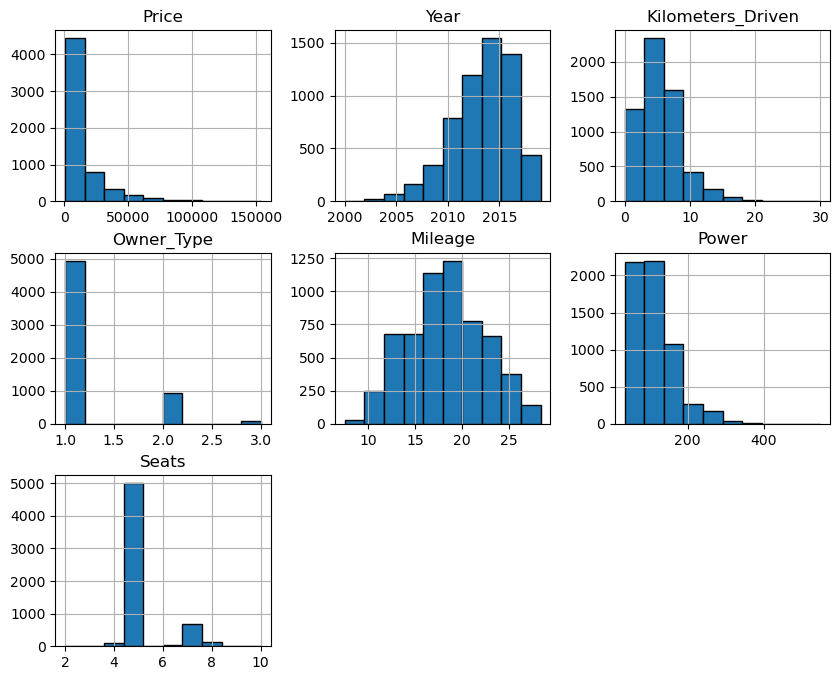

In [27]:
for_graph = outlier_process_done.select_dtypes(exclude='object')
for_graph['Kilometers_Driven'] = for_graph['Kilometers_Driven']/10000
for_graph.hist(figsize=(10, 8), edgecolor='black')

# 2. 파생변수 생성

In [28]:
# Year -> 차량나이
plus_carage_df = outlier_process_done.copy()
plus_carage_df['Car_Age'] = (2020 - plus_carage_df['Year']).astype(int)
plus_carage_df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Seats_cat,Brand,Car_Age
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,1,19.67,126.20,5.0,medium,Hyundai,5
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,1,18.20,88.70,5.0,medium,Honda,9
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,1,20.77,88.76,7.0,large,Maruti,8
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,2,15.20,140.80,5.0,medium,Audi,7
6,Nissan Micra Diesel XV,Jaipur,5365.36,2013,86999,Diesel,Manual,1,23.08,63.10,5.0,medium,Nissan,7


In [29]:
# 필요없는 컬럼 삭제

pre_data = plus_carage_df.drop(['Name','Year','Seats'], axis = 1).reset_index(drop=True)
pre_data.head()

,Location,Price,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats_cat,Brand,Car_Age
0,Pune,19162.00,41000,Diesel,Manual,1,19.67,126.20,medium,Hyundai,5
1,Chennai,6898.32,46000,Petrol,Manual,1,18.20,88.70,medium,Honda,9
2,Chennai,9197.76,87000,Diesel,Manual,1,20.77,88.76,large,Maruti,8
3,Coimbatore,27194.71,40670,Diesel,Automatic,2,15.20,140.80,medium,Audi,7
4,Jaipur,5365.36,86999,Diesel,Manual,1,23.08,63.10,medium,Nissan,7


In [30]:
pre_data.describe()

,Price,Kilometers_Driven,Owner_Type,Mileage,Power,Car_Age
count,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000
mean,15153.003195,56087.522666,1.188046,18.356125,113.626286,6.429147
std,17422.504728,33419.571437,0.430451,4.096734,53.215119,3.135697
min,674.500000,171.000000,1.000000,7.500000,34.200000,1.000000
25%,5595.300000,32759.750000,1.000000,15.400000,78.000000,4.000000
50%,8967.820000,52000.000000,1.000000,18.400000,98.600000,6.000000
75%,16326.020000,72000.000000,1.000000,21.100000,138.575000,8.000000
max,153296.000000,300000.000000,3.000000,28.400000,550.000000,20.000000


In [31]:
pre_data.to_csv("./car_data_preprocessing.csv", index=False)
pre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5956 non-null   object 
 1   Price              5956 non-null   float64
 2   Kilometers_Driven  5956 non-null   int64  
 3   Fuel_Type          5956 non-null   object 
 4   Transmission       5956 non-null   object 
 5   Owner_Type         5956 non-null   int64  
 6   Mileage            5956 non-null   float64
 7   Power              5956 non-null   float64
 8   Seats_cat          5956 non-null   object 
 9   Brand              5956 non-null   object 
 10  Car_Age            5956 non-null   int32  
dtypes: float64(3), int32(1), int64(2), object(5)
memory usage: 488.7+ KB


# 3.스케일링 및 더미데이터 생성

- 사용할 모델
1. Tree 기반
    - Decision Tree
    - Random Forest
    - Gradient Boosting
   -  데이터: 더미 + 스케일(x)
2. 회귀분석
    - 다중회귀분석
   - 데이터: 더미 + 스케일링(o)

In [32]:
# 연속형 변수
continue_cols = ['Kilometers_Driven', 'Mileage', 'Power']

# 범주형 변수
category_cols = ['Location', 'Fuel_Type', 'Transmission', 'Seats_cat', 'Brand']

#스케일러 정의
mm_scaler = MinMaxScaler() 
std_scaler = StandardScaler()

try:
    display(pre_data)
except:
    pre_data = pd.read_csv("./car_data_preprocessing.csv")


x_data_car = pre_data.drop(['Price'], axis = 1)
y_data_car = pre_data['Price']

# tree data
tree_x_data = pd.get_dummies(x_data_car)
tree_y_data = y_data_car.copy()

# 회귀모델 데이터
# x data 스케일러
x_mm_data = x_data_car.copy()
x_std_data = x_data_car.copy()

x_mm_data[continue_cols] = pd.DataFrame(mm_scaler.fit_transform(x_mm_data[continue_cols]))
x_std_data[continue_cols] = pd.DataFrame(std_scaler.fit_transform(x_std_data[continue_cols]))

x_mm_data = pd.get_dummies(x_mm_data)
x_std_data = pd.get_dummies(x_std_data)

# y data 스케일러
y_mm_data = mm_scaler.fit_transform(y_data_car.values.reshape(-1, 1))
y_std_data = std_scaler.fit_transform(y_data_car.values.reshape(-1, 1))

display(tree_x_data.head())
display(x_mm_data.head())
display(x_std_data.head())
display(y_mm_data)

,Location,Price,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats_cat,Brand,Car_Age
0,Pune,19162.00,41000,Diesel,Manual,1,19.67,126.20,medium,Hyundai,5
1,Chennai,6898.32,46000,Petrol,Manual,1,18.20,88.70,medium,Honda,9
2,Chennai,9197.76,87000,Diesel,Manual,1,20.77,88.76,large,Maruti,8
3,Coimbatore,27194.71,40670,Diesel,Automatic,2,15.20,140.80,medium,Audi,7
4,Jaipur,5365.36,86999,Diesel,Manual,1,23.08,63.10,medium,Nissan,7
...,...,...,...,...,...,...,...,...,...,...,...
5951,Chennai,8477.27,36000,Petrol,Manual,1,19.83,67.00,medium,Datsun,4
5952,Pune,10822.70,41413,Diesel,Manual,1,27.28,69.00,medium,Tata,4
5953,Kochi,13474.72,39015,Petrol,Manual,1,17.00,121.36,medium,Ford,3
5954,Mumbai,27838.55,6000,Petrol,Manual,1,16.00,160.00,medium,Jeep,2


,Kilometers_Driven,Owner_Type,Mileage,Power,Car_Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Brand_Mini,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,41000,1,19.67,126.20,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,46000,1,18.20,88.70,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87000,1,20.77,88.76,8,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40670,2,15.20,140.80,7,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,86999,1,23.08,63.10,7,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


,Kilometers_Driven,Owner_Type,Mileage,Power,Car_Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Brand_Mini,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,0.136174,1,0.582297,0.178364,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.152850,1,0.511962,0.105661,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.289595,1,0.634928,0.105777,8,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.135074,2,0.368421,0.206669,7,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.289592,1,0.745455,0.056029,7,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


,Kilometers_Driven,Owner_Type,Mileage,Power,Car_Age,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Brand_Mini,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,-0.451496,1,0.320740,0.236301,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.301870,1,-0.038113,-0.468445,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.925059,1,0.589269,-0.467318,8,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.461371,2,-0.770465,0.510682,7,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.925029,1,1.153180,-0.949552,7,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


array([[0.121133  ],
       [0.04077944],
       [0.05584574],
       ...,
       [0.08386905],
       [0.17798312],
       [0.10174772]])

# 4. 사용할 함수 정의

In [33]:
# 데이터 스플릿 함수

def make_data(x_data, y_data, print_mode = 0):
    df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=661)

    if print_mode == 1:
        print("df_train_x:",df_train_x.shape)
        print("df_test_x:",df_test_x.shape)
        print("df_train_y:",df_train_y.shape)
        print("df_test_y:",df_test_y.shape)

    return df_train_x, df_test_x, df_train_y, df_test_y

In [34]:
# 하이퍼파라미터 조합 만들기

import numpy as np

def make_hyperparameters(model_name):
    if model_name == 'dt':
        h_dict = {
            'max_depth' : [x for x in range(7, 20)],
            'min_samples_split' : [x * 3 for x in range(3, 21)],
            'min_samples_leaf' : [x * 2 for x in range(3, 21)]
             
            #'max_depth' : [5]
        }
    elif model_name == 'rf':
        h_dict = {
            'n_estimators' : [x * 10 for x in range(1, 30, 2)], 
            'max_depth' : [x for x in range(7, 20)],
            'min_samples_split' : [x * 3 for x in range(3, 21)],
            'min_samples_leaf' : [x * 2 for x in range(2, 20)]
        } 
    elif model_name == 'gb':
        h_dict = {
            'lr' : [x * 0.01 for x in range(1,10)],
            'n_estimators' : [x * 10 for x in range(1, 30, 2)],
            'max_depth' : [x for x in range(7, 20)],
            'min_samples_split' : [x * 3 for x in range(3, 21)],
            'min_samples_leaf' : [x * 2 for x in range(2, 20)]
        } 
    else:
        h_dict = {'lr': [0.01, 0.1, 1, 10]}  

    return h_dict

In [35]:
def make_base_params(model_name):
    if model_name == 'dt':
        h_dict = {
            'max_depth' : [None],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1]     
        }      
    elif model_name == 'rf':
        h_dict = {
            'n_estimators' : [100],
            'max_depth' : [None],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1]  
        }        
    elif model_name == 'gb':
        h_dict = {
            'lr' : [0.1],
            'n_estimators' : [100],
            'max_depth' : [3],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1]
        }         
    else:
        h_dict = {'a': [1]}  

    return h_dict

In [36]:
# metric list 보이기

def make_metric_list(y_true, y_pred, mode = 0): # mode = 0, 스케일링안한거, 1 - Minmax, 2 - std
    m_list = []
    # print(y_true.shape)
    # print(y_pred.shape)
    if mode == 1: # MinMaxscaler
        y_true = mm_scaler.inverse_transform(y_true)
        y_pred = mm_scaler.inverse_transform(y_pred)
        y_true, y_pred = y_true.flatten(), y_pred.flatten()
        
    elif mode == 2: # StandardScaler
        y_true = std_scaler.inverse_transform(y_true)
        y_pred = std_scaler.inverse_transform(y_pred)
        y_true, y_pred = y_true.flatten(), y_pred.flatten()
        
    elif mode == 3: # log
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared = False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    m_list = [mse, rmse, mae, mape]

    return m_list

In [37]:
# 예측결과 프린팅

def show_the_pred_result(y_true, y_pred, mm_scaler, std_scaler, model_name, mode = 0, show = 0, draw = 0):
    if show == 1:
        if mode == 1: # MinMaxscaler
            y_true = mm_scaler.inverse_transform(y_true)
            y_pred = mm_scaler.inverse_transform(y_pred)
        elif mode == 2: # StandardScaler
            y_true = std_scaler.inverse_transform(y_true)
            y_pred = std_scaler.inverse_transform(y_pred)
            
        y_true, y_pred = y_true.flatten(), y_pred.flatten()
        #print(y_true)
        #print(y_pred)
        df_view = pd.DataFrame({
            'True' : y_true[:10], 
            'Predict' : y_pred[:10].round(3) })
        df_view['diff'] = df_view['True'] - df_view['Predict']
        display(df_view)

    if draw == 1:
        plt.figure(figsize=(8, 4))
        plt.scatter(y_true, y_pred, color='blue', label='Predicted vs True')
        sns.regplot(x=y_true, y=y_pred, scatter=False, color='red', line_kws={"color": "red", "linewidth": 2})

        plt.title(f'{model_name} prediction', fontsize=15)
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)

        plt.legend()

In [38]:
# 하이퍼파라미터 조합 만들기

def generate_param_combinations(param_grid):
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    combinations = list(product(*param_values))
    
    param_combinations = []
    for combination in combinations:
        param_combinations.append(dict(zip(param_names, combination)))
    
    return param_combinations

# 트리계열 모델 학습하기

def run_models(m_params, train_x, train_y, test_x, test_y, model_name, param_name, plt_mode = 0):
    train_score = []
    test_score = []
    pre_train_s = -1
    pre_test_s = -1
    rs = 661

    params_comb = generate_param_combinations(m_params)
    #print(params_comb)
    for index, p in enumerate(params_comb):
        #print(index, "train")
        if model_name == 'dt':
            model = DecisionTreeRegressor(random_state = rs,  
                                          max_depth= p['max_depth'],
                                          min_samples_split= p['min_samples_split'],
                                          min_samples_leaf= p['min_samples_leaf']
                                        )
        elif model_name == 'rf':
            model = RandomForestRegressor(random_state = rs,
                                          n_estimators= p['n_estimators'], 
                                          max_depth= p['max_depth'],
                                          min_samples_split= p['min_samples_split'],
                                          min_samples_leaf= p['min_samples_leaf']
                                        )
        elif model_name == 'gb':
            model = GradientBoostingRegressor(random_state = rs, 
                                              learning_rate= p['lr'],
                                              n_estimators= p['n_estimators'], 
                                              max_depth= p['max_depth'],
                                              min_samples_split= p['min_samples_split'],
                                              min_samples_leaf= p['min_samples_leaf']
                                              )
        model.fit(train_x, train_y)
        train_s = model.score(train_x, train_y)
        test_s = model.score(test_x, test_y)
        if index != 0:
            pre_train_s = train_score[-1]
            pre_test_s = test_score[-1]
        train_score.append(train_s)
        test_score.append(test_s)
        
        if test_s < pre_test_s and train_s > pre_train_s:
            print("Ealry Stopping")
            print(f"pre_test: {pre_test_s} \n present_test: {test_s}")
            m_params[param_name] = m_params[param_name][:index+1]
            break        
                 
    df_score = pd.DataFrame()
    df_score[param_name] = m_params[param_name]
    df_score["TrainScore"] = train_score
    df_score["TestScore"] = test_score

    if plt_mode == 1:
        df_score_fill = df_score.fillna(0)
        display(df_score)
        plt.figure(figsize=(10, 3))
        plt.plot(df_score_fill[param_name], df_score_fill["TrainScore"], label = "Train score")
        plt.plot(df_score_fill[param_name], df_score_fill["TestScore"], label = "Test score")
        plt.legend()
        plt.show()
    
    return df_score, model

In [39]:
def run_tuning(t_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name, mode = 0):
    base_params = make_base_params(model_name)
    for index, param_name in enumerate(t_params):
        print(param_name)
        base_params[param_name] = t_params[param_name]
        df_score, _= run_models(base_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name, param_name, plt_mode = 1)
        best_param = df_score.sort_values('TestScore', ascending=False).fillna(0).iloc[0,0]
        if best_param == 0:
            best_param = [None]
        else:
            best_param = [best_param]
        print(f'{param_name} is done: {best_param}')
        base_params[param_name] = best_param
        
    print("base_param", base_params)
    _, best_model = run_models(base_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name, param_name)
    y_pred = best_model.predict(df_test_x)
    
    metric_list = make_metric_list(df_test_y, y_pred)
    return base_params, best_model, metric_list

# 5. 사용할 모델 정의 및 학습

In [40]:
all_metric_list = pd.DataFrame()

## Tree model

### Decision Tree

max_depth
Ealry Stopping
pre_test: 0.7585222618092511 
 present_test: 0.7527569191556132


,max_depth,TrainScore,TestScore
0,7,0.910688,0.758522
1,8,0.929695,0.752757


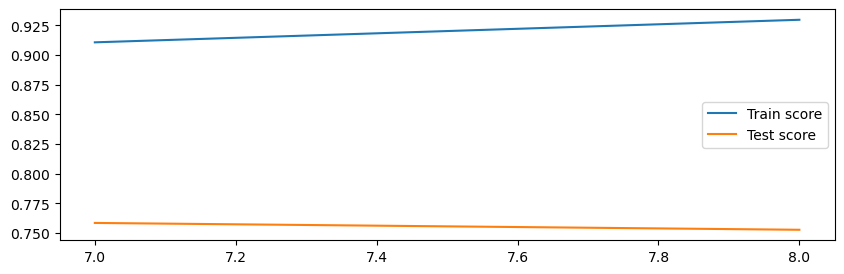

max_depth is done: [7]
min_samples_split


,min_samples_split,TrainScore,TestScore
0,9,0.900133,0.748834
1,12,0.899005,0.743707
2,15,0.897116,0.737293
3,18,0.896561,0.737549
4,21,0.895360,0.736081
5,24,0.890517,0.743820
6,27,0.889865,0.743605
7,30,0.889234,0.744036
8,33,0.882280,0.750622
9,36,0.875963,0.760376


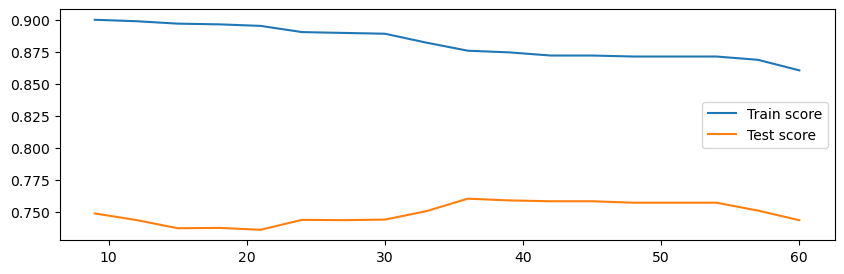

min_samples_split is done: [36]
min_samples_leaf


,min_samples_leaf,TrainScore,TestScore
0,6,0.864865,0.758658
1,8,0.862146,0.753013
2,10,0.861254,0.751970
3,12,0.858681,0.746614
4,14,0.858197,0.743781
5,16,0.857295,0.740151
6,18,0.856203,0.739681
7,20,0.855306,0.739080
8,22,0.853886,0.742974
9,24,0.851127,0.742478


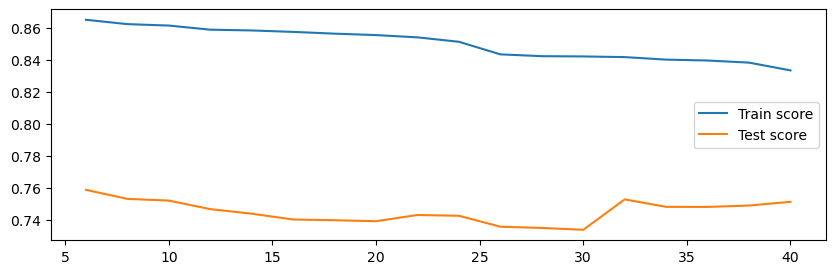

min_samples_leaf is done: [6]
base_param {'max_depth': [7], 'min_samples_split': [36], 'min_samples_leaf': [6]}


In [41]:
model_name = 'dt'
dt_params = make_hyperparameters(model_name)
df_train_x, df_test_x, df_train_y, df_test_y = make_data(tree_x_data, tree_y_data)

dt_bast_params, dt_best_model, metric_list = run_tuning(dt_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name)
r2 = dt_best_model.score(df_test_x, df_test_y)
metric_list.append(r2)

In [42]:
all_metric_list[model_name] = metric_list
all_metric_list

,dt
0,6.392261e+07
1,7.995161e+03
2,3.757947e+03
3,3.337407e-01
4,7.586581e-01


### Random Forest

n_estimators
Ealry Stopping
pre_test: 0.8332173921318092 
 present_test: 0.832562754955478


,n_estimators,TrainScore,TestScore
0,10,0.977703,0.821168
1,30,0.982922,0.830453
2,50,0.983111,0.830825
3,70,0.983831,0.833217
4,90,0.984185,0.832563


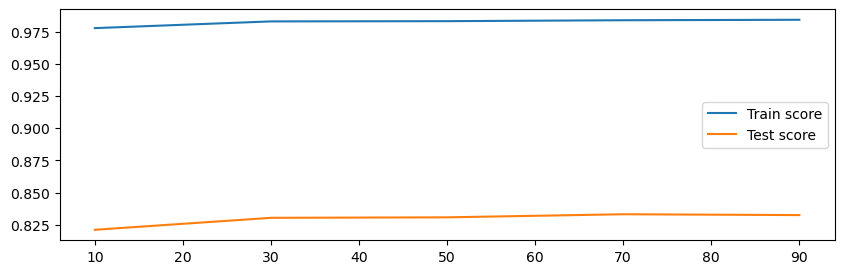

n_estimators is done: [70]
max_depth
Ealry Stopping
pre_test: 0.8324599174016608 
 present_test: 0.8316906872738163


,max_depth,TrainScore,TestScore
0,7,0.935377,0.814502
1,8,0.950832,0.822097
2,9,0.961511,0.823427
3,10,0.968736,0.828448
4,11,0.974228,0.828994
5,12,0.977749,0.829723
6,13,0.980164,0.829944
7,14,0.981612,0.832460
8,15,0.982485,0.831691


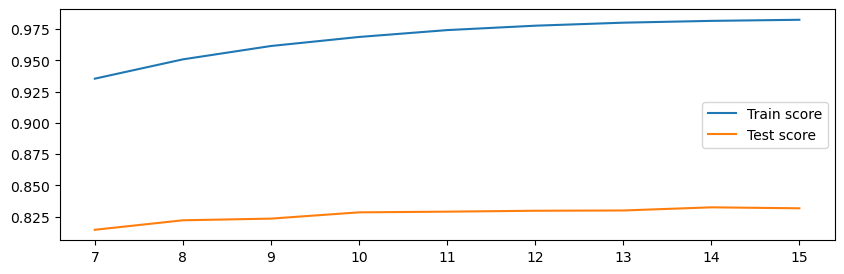

max_depth is done: [14]
min_samples_split


,min_samples_split,TrainScore,TestScore
0,9,0.960269,0.831989
1,12,0.952328,0.831722
2,15,0.945946,0.828940
3,18,0.938651,0.828262
4,21,0.932462,0.825166
5,24,0.927322,0.823274
6,27,0.921900,0.822454
7,30,0.918385,0.820513
8,33,0.914771,0.817416
9,36,0.909923,0.814200


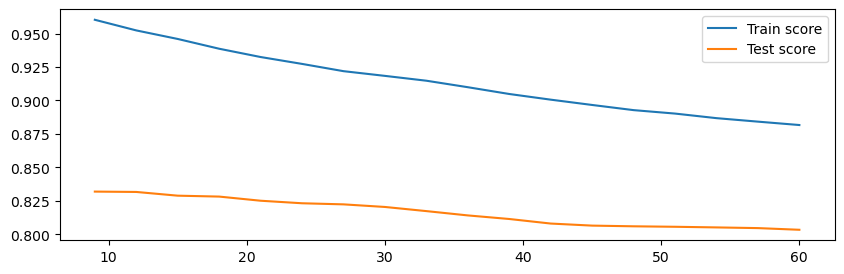

min_samples_split is done: [9]
min_samples_leaf


,min_samples_leaf,TrainScore,TestScore
0,4,0.937836,0.824632
1,6,0.921484,0.819023
2,8,0.907894,0.811406
3,10,0.897046,0.803907
4,12,0.888860,0.799966
5,14,0.883056,0.793994
6,16,0.878532,0.789291
7,18,0.873536,0.787481
8,20,0.868991,0.784551
9,22,0.864512,0.782456


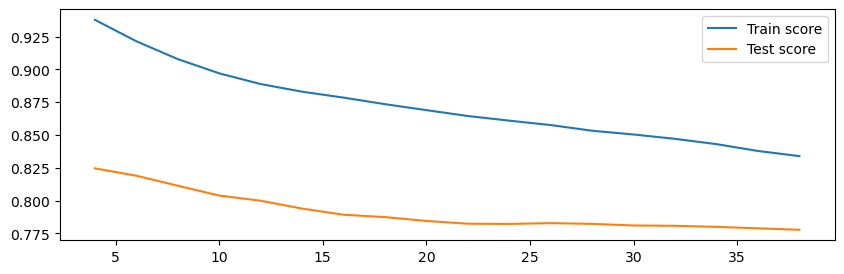

min_samples_leaf is done: [4]
base_param {'n_estimators': [70], 'max_depth': [14], 'min_samples_split': [9], 'min_samples_leaf': [4]}


In [43]:
model_name = 'rf'
rf_params = make_hyperparameters(model_name)
df_train_x, df_test_x, df_train_y, df_test_y = make_data(tree_x_data, tree_y_data)

rf_bast_params, rf_best_model, metric_list = run_tuning(rf_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name)
metric_list.append(rf_best_model.score(df_test_x, df_test_y))

In [44]:
all_metric_list[model_name] = metric_list
all_metric_list

,dt,rf
0,6.392261e+07,4.644865e+07
1,7.995161e+03,6.815325e+03
2,3.757947e+03,2.852341e+03
3,3.337407e-01,2.645416e-01
4,7.586581e-01,8.246316e-01


### Gradient Boosting

lr


,lr,TrainScore,TestScore
0,0.01,0.692161,0.672102
1,0.02,0.831428,0.775476
2,0.03,0.876247,0.796405
3,0.04,0.894219,0.799569
4,0.05,0.904341,0.803879
5,0.06,0.910115,0.805855
6,0.07,0.915098,0.807412
7,0.08,0.918890,0.812479
8,0.09,0.923668,0.812760


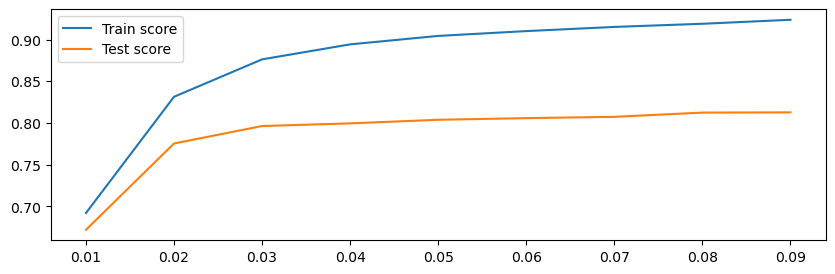

lr is done: [0.09]
n_estimators
Ealry Stopping
pre_test: 0.8275591643828475 
 present_test: 0.8271712401034723


,n_estimators,TrainScore,TestScore
0,10,0.675210,0.657371
1,30,0.869930,0.793431
2,50,0.901541,0.802242
3,70,0.912802,0.808784
4,90,0.920966,0.812174
5,110,0.926789,0.814363
6,130,0.932676,0.818414
7,150,0.938004,0.821256
8,170,0.942076,0.823819
9,190,0.945134,0.824525


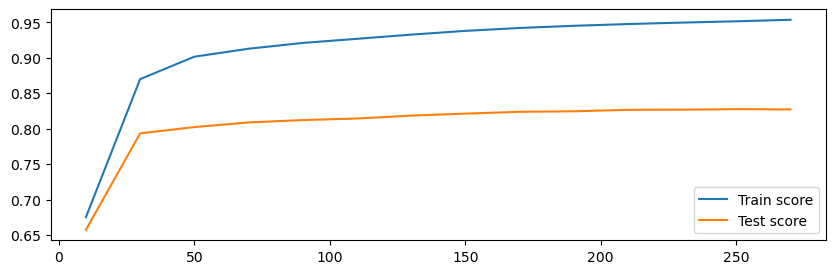

n_estimators is done: [250]
max_depth
Ealry Stopping
pre_test: 0.8305606662820484 
 present_test: 0.821154724370612


,max_depth,TrainScore,TestScore
0,7,0.997450,0.824203
1,8,0.998986,0.830561
2,9,0.999638,0.821155


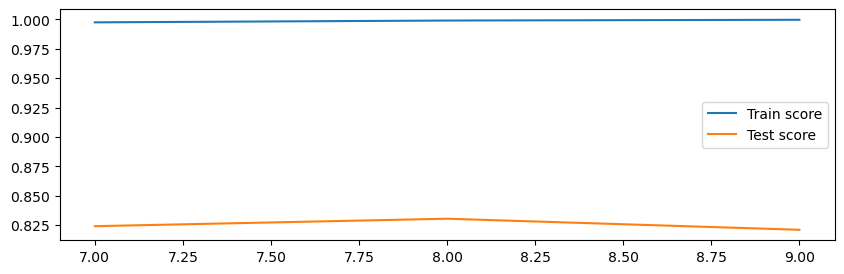

max_depth is done: [8]
min_samples_split
Ealry Stopping
pre_test: 0.8333843447571825 
 present_test: 0.8260712909898181


,min_samples_split,TrainScore,TestScore
0,9,0.998268,0.824801
1,12,0.997657,0.829916
2,15,0.996871,0.832183
3,18,0.996404,0.824514
4,21,0.995574,0.825391
5,24,0.995146,0.827483
6,27,0.994096,0.833384
7,30,0.994140,0.826071


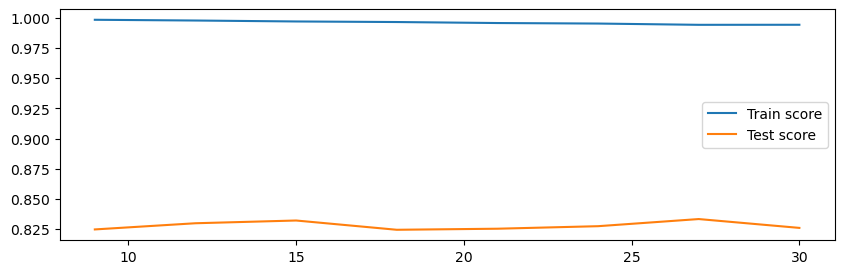

min_samples_split is done: [27]
min_samples_leaf


,min_samples_leaf,TrainScore,TestScore
0,4,0.990437,0.846440
1,6,0.987784,0.847676
2,8,0.985942,0.852953
3,10,0.981769,0.850122
4,12,0.978213,0.847284
5,14,0.976959,0.841830
6,16,0.973825,0.839423
7,18,0.971613,0.841697
8,20,0.968191,0.840676
9,22,0.965381,0.841356


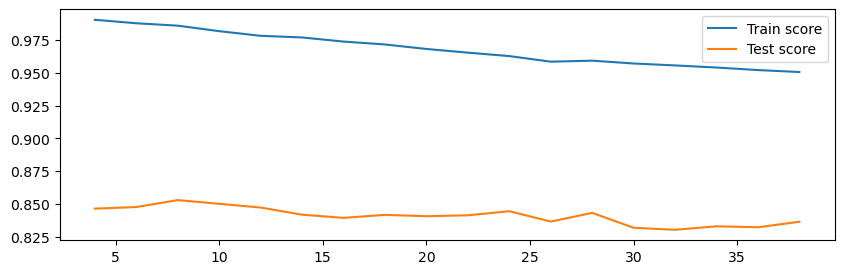

min_samples_leaf is done: [8]
base_param {'lr': [0.09], 'n_estimators': [250], 'max_depth': [8], 'min_samples_split': [27], 'min_samples_leaf': [8]}


In [45]:
model_name = 'gb'
gb_params = make_hyperparameters(model_name)
df_train_x, df_test_x, df_train_y, df_test_y = make_data(tree_x_data, tree_y_data)

gb_bast_params, gb_best_model, metric_list = run_tuning(gb_params, df_train_x, df_train_y, df_test_x, df_test_y, model_name)
metric_list.append(gb_best_model.score(df_test_x, df_test_y))

In [46]:
all_metric_list[model_name] = metric_list
all_metric_list

,dt,rf,gb
0,6.392261e+07,4.644865e+07,3.894723e+07
1,7.995161e+03,6.815325e+03,6.240771e+03
2,3.757947e+03,2.852341e+03,2.466482e+03
3,3.337407e-01,2.645416e-01,2.393579e-01
4,7.586581e-01,8.246316e-01,8.529535e-01


## Linear Regression

### MinMaxscaler Linear Regression

In [47]:
model_name = 'MM_LinReg'
df_train_x, df_test_x, df_train_y, df_test_y = make_data(x_mm_data, y_mm_data)
mm_lin_reg = LinearRegression()
mm_lin_reg.fit(df_train_x, df_train_y)

LinearRegression()

In [48]:
# 예측 결과 확인하기
lin_reg_pred = mm_lin_reg.predict(df_test_x)
r2 = mm_lin_reg.score(df_test_x, df_test_y)

metric_list = make_metric_list(df_test_y, lin_reg_pred, 1)
metric_list.append(r2)
all_metric_list[model_name] = metric_list

In [49]:
show_the_pred_result(df_test_y, lin_reg_pred, mm_scaler, std_scaler, model_name, 1,1,0)

,True,Predict,diff
0,1686.26,-6025.659,7711.919
1,4598.88,7542.770,-2943.890
2,8753.20,10204.320,-1451.120
3,6898.32,7827.032,-928.712
4,16555.97,17878.361,-1322.391
5,4522.23,1528.594,2993.636
6,6131.84,10127.614,-3995.774
7,11880.44,11415.597,464.843
8,2529.38,-1951.098,4480.478
9,3065.92,-2618.596,5684.516


### StandardScaler Linear Regression

In [50]:
model_name = 'std_LinReg'

df_train_x, df_test_x, df_train_y, df_test_y = make_data(x_std_data, y_std_data)
std_lin_reg = LinearRegression()
std_lin_reg.fit(df_train_x, df_train_y)

LinearRegression()

In [51]:
# 예측 결과 확인하기
lin_reg_pred = std_lin_reg.predict(df_test_x)
r2 = std_lin_reg.score(df_test_x, df_test_y)

metric_list = make_metric_list(df_test_y, lin_reg_pred, 2)
metric_list.append(r2)
all_metric_list[model_name] = metric_list

In [52]:
all_metric_list

,dt,rf,gb,MM_LinReg,std_LinReg
0,6.392261e+07,4.644865e+07,3.894723e+07,6.843481e+07,6.843261e+07
1,7.995161e+03,6.815325e+03,6.240771e+03,8.272533e+03,8.272401e+03
2,3.757947e+03,2.852341e+03,2.466482e+03,4.771001e+03,4.770835e+03
3,3.337407e-01,2.645416e-01,2.393579e-01,6.207682e-01,6.207280e-01
4,7.586581e-01,8.246316e-01,8.529535e-01,7.416221e-01,7.416304e-01


In [53]:
show_the_pred_result(df_test_y, lin_reg_pred, mm_scaler, std_scaler, model_name, 2,1,0)

,True,Predict,diff
0,1686.26,-6024.425,7710.685
1,4598.88,7540.903,-2942.023
2,8753.20,10203.107,-1449.907
3,6898.32,7828.576,-930.256
4,16555.97,17878.812,-1322.842
5,4522.23,1528.985,2993.245
6,6131.84,10126.776,-3994.936
7,11880.44,11416.392,464.048
8,2529.38,-1950.455,4479.835
9,3065.92,-2618.626,5684.546


### Log Linear Regression

In [54]:
# 데이터 log 스케일링
x_log_scaled = x_data_car.copy()
x_log_scaled[continue_cols] = pd.DataFrame(np.log1p(x_data_car[continue_cols]))
x_log_scaled = pd.get_dummies(x_log_scaled)

y_log_scaled = y_data_car.copy()
y_log_scaled = pd.DataFrame(np.log1p(y_data_car))


model_name = 'log_LinReg'

df_train_x, df_test_x, df_train_y, df_test_y = make_data(x_log_scaled, y_log_scaled)
log_lin_reg = LinearRegression()
log_lin_reg.fit(df_train_x, df_train_y)

LinearRegression()

In [55]:
# 예측 결과 확인하기
lin_reg_pred = log_lin_reg.predict(df_test_x)
r2 = log_lin_reg.score(df_test_x, df_test_y)

metric_list = make_metric_list(df_test_y, lin_reg_pred, 3)
metric_list.append(r2)
all_metric_list[model_name] = metric_list

In [56]:
all_metric_list

,dt,rf,gb,MM_LinReg,std_LinReg,log_LinReg
0,6.392261e+07,4.644865e+07,3.894723e+07,6.843481e+07,6.843261e+07,5.273780e+07
1,7.995161e+03,6.815325e+03,6.240771e+03,8.272533e+03,8.272401e+03,7.262079e+03
2,3.757947e+03,2.852341e+03,2.466482e+03,4.771001e+03,4.770835e+03,2.865926e+03
3,3.337407e-01,2.645416e-01,2.393579e-01,6.207682e-01,6.207280e-01,2.557067e-01
4,7.586581e-01,8.246316e-01,8.529535e-01,7.416221e-01,7.416304e-01,8.927895e-01


# 6. 모델 성능 비교

In [57]:
all_metric_list

,dt,rf,gb,MM_LinReg,std_LinReg,log_LinReg
0,6.392261e+07,4.644865e+07,3.894723e+07,6.843481e+07,6.843261e+07,5.273780e+07
1,7.995161e+03,6.815325e+03,6.240771e+03,8.272533e+03,8.272401e+03,7.262079e+03
2,3.757947e+03,2.852341e+03,2.466482e+03,4.771001e+03,4.770835e+03,2.865926e+03
3,3.337407e-01,2.645416e-01,2.393579e-01,6.207682e-01,6.207280e-01,2.557067e-01
4,7.586581e-01,8.246316e-01,8.529535e-01,7.416221e-01,7.416304e-01,8.927895e-01


In [58]:
def show_metric_list(model_names, metric_columns, metric_df):
    metric_df.columns = model_names
    print_metric = pd.DataFrame(metric_df.T)
    print_metric.columns = metric_columns

    std_scaler = StandardScaler()
    draw_metric = std_scaler.fit_transform(print_metric)
    draw_metric = pd.DataFrame(draw_metric, columns=metric_columns, index = model_names)

    # MSE, RMSE, MAE, MAPE는 값이 작을수록, R2는 값이 높을수록 모델의 성능이 뛰어난것임
    draw_metric.plot.bar(rot = 0, figsize=(10,4))
    plt.legend(loc="upper left"); plt.grid(axis = "y")

    return print_metric
    

In [59]:
# 예측 및 매트릭 데이터 추출
def get_metric_list(x_list, y_true_list, model_list, mode_list, model_names):
    all_ml = pd.DataFrame()
    y_pred_list = []
    for i in range(6):
        #print(model_names[i])
        # best 모델로 예측
        y_pred = model_list[i].predict(x_list[i])
        # print(y_true_list[i].shape)
        # print(y_pred.shape)
        if mode_list[i] == 0:
            y_pred = y_pred.reshape(-1, 1)
        #metric 리스트 추출
        metric_list = make_metric_list(y_true_list[i], y_pred, mode = mode_list[i])
        r2 = model_list[i].score(x_list[i], y_true_list[i])
        metric_list.append(r2)
        y_pred_list.append(y_pred)
        #매트릭 추가
        all_ml[model_names[i]] = metric_list
    return all_ml, y_pred_list
            

In [60]:
# 성능 시각화에 사용할 리스트 정의 및 all_metric_list 변환

metric_columns = ['MSE', 'RMSE','MAE','MAPE','R2']
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'MinMax-LinReg', 'STD-LinReg', 'Log-LinReg']
model_list = [dt_best_model, rf_best_model, gb_best_model, mm_lin_reg, std_lin_reg, log_lin_reg]
graphs = []
modes = [0,0,0,1,2,3]

In [61]:
# 모델 저장
for i in range(6):
    joblib.dump(model_list[i], "./"+model_names[i]+'.pkl') 

In [62]:
# 성능 비교를 위한 데이터 추출

tree_train_x, tree_test_x, tree_train_y, tree_test_y = make_data(tree_x_data, tree_y_data)
std_train_x, std_test_x, std_train_y, std_test_y = make_data(x_std_data, y_std_data)
mm_train_x, mm_test_x, mm_train_y, mm_test_y = make_data(x_mm_data, y_mm_data)
log_train_x, log_test_x, log_train_y, log_test_y = make_data(x_log_scaled, y_log_scaled)

In [63]:
x_train_list = [tree_train_x,tree_train_x,tree_train_x,mm_train_x,std_train_x,log_train_x]
x_test_list = [tree_test_x,tree_test_x,tree_test_x,mm_test_x,std_test_x,log_test_x]
y_true_list_train = [tree_train_y,tree_train_y,tree_train_y,mm_train_y,std_train_y,log_train_y]
y_true_list_test = [tree_test_y,tree_test_y,tree_test_y,mm_test_y,std_test_y,log_test_y]

In [64]:
train_metric_all, train_pred = get_metric_list(x_train_list, y_true_list_train, model_list, modes, model_names)
test_metric_all, test_pred = get_metric_list(x_test_list, y_true_list_test, model_list, modes, model_names)

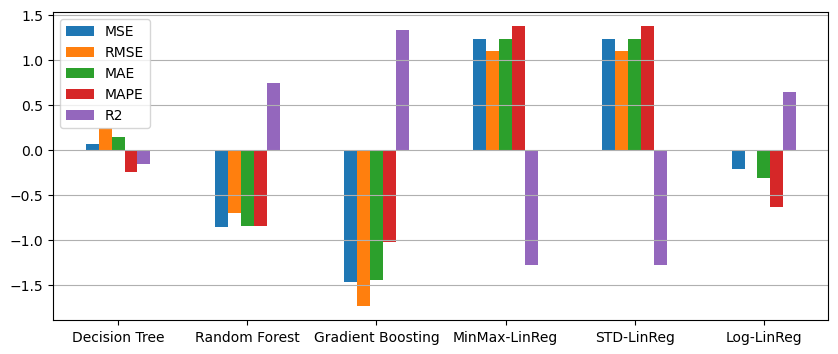

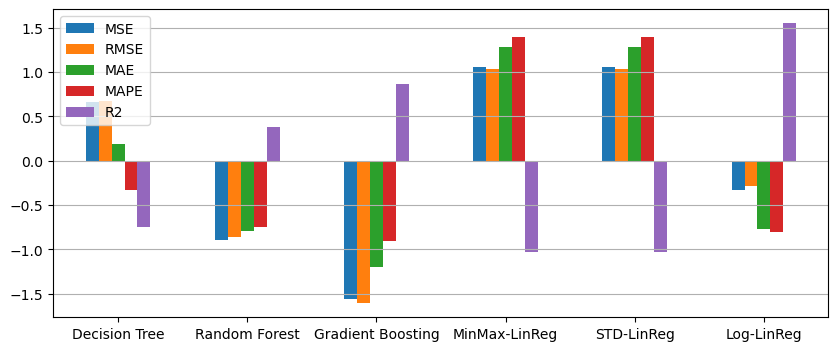

In [65]:
print_metric_train =show_metric_list(model_names, metric_columns, train_metric_all)
print_metric_test =show_metric_list(model_names, metric_columns, test_metric_all)

In [66]:
print("Train 데이터셋에 대한 성능지표")
display(print_metric_train)
print("Test 데이터셋에 대한 성능지표")
display(print_metric_test)

Train 데이터셋에 대한 성능지표


,MSE,RMSE,MAE,MAPE,R2
Decision Tree,4.324971e+07,6576.451495,3270.327170,0.248279,0.864865
Random Forest,1.989551e+07,4460.438497,1955.465949,0.133397,0.937836
Gradient Boosting,4.499177e+06,2121.126355,1159.316148,0.100358,0.985942
MinMax-LinReg,7.253746e+07,8516.892527,4731.969903,0.554059,0.773355
STD-LinReg,7.253739e+07,8516.888675,4731.849395,0.554029,0.773355
Log-LinReg,3.620705e+07,6017.229791,2673.944265,0.173461,0.929753


Test 데이터셋에 대한 성능지표


,MSE,RMSE,MAE,MAPE,R2
Decision Tree,6.392261e+07,7995.161384,3757.947204,0.333741,0.758658
Random Forest,4.644865e+07,6815.324720,2852.341388,0.264542,0.824632
Gradient Boosting,3.894723e+07,6240.771310,2466.482400,0.239358,0.852953
MinMax-LinReg,6.843481e+07,8272.533318,4771.001130,0.620768,0.741622
STD-LinReg,6.843261e+07,8272.400569,4770.834744,0.620728,0.741630
Log-LinReg,5.273780e+07,7262.079436,2865.926091,0.255707,0.892790


In [67]:
print_metric_train.to_csv("./train_metrics.csv")
print_metric_test.to_csv("./test_metrics.csv")

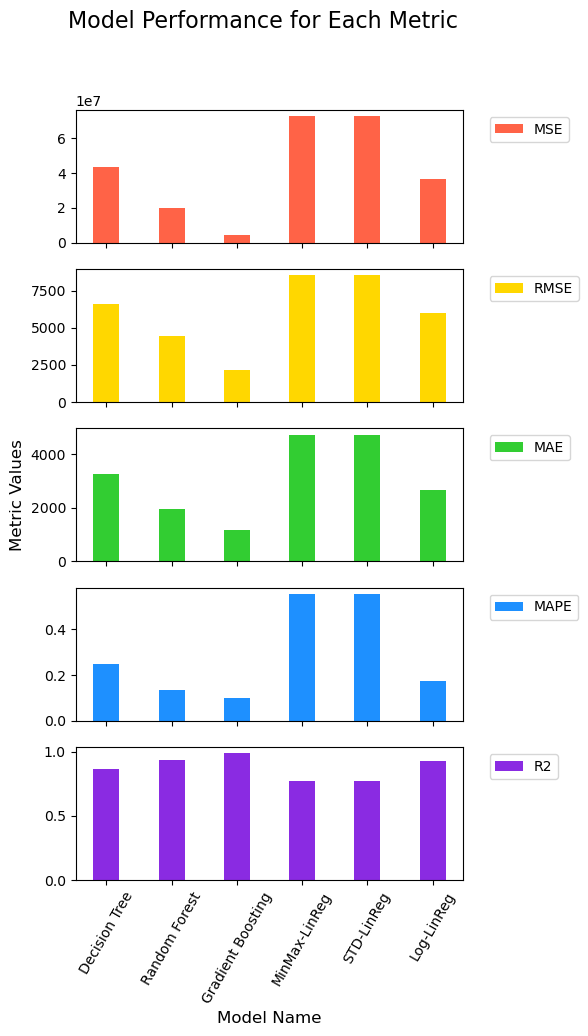

In [68]:
fig, axes = plt.subplots(5, 1, figsize=(5, 10)) 

plt.suptitle("Model Performance for Each Metric", fontsize=16)
colors = ['#FF6347', '#FFD700', '#32CD32', '#1E90FF', '#8A2BE2']

for i in range(5):
    axes[i].bar(print_metric_train.index, print_metric_train.iloc[:, i], label=metric_columns[i], color=colors[i], width=0.4)
    if i != 4:
        axes[i].tick_params(axis='x', labelbottom=False)
        
    axes[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

axes[2].set_ylabel('Metric Values', fontsize=12) 
axes[-1].set_xlabel('Model Name', fontsize=12)
axes[-1].tick_params(axis='x', rotation=60) 
plt.show()

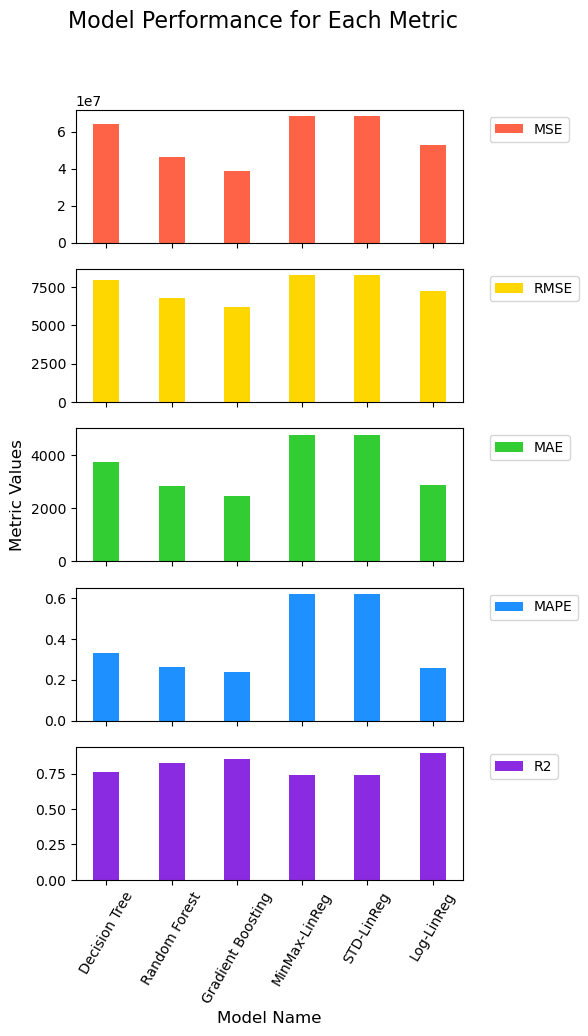

In [69]:
fig, axes = plt.subplots(5, 1, figsize=(5, 10)) 

plt.suptitle("Model Performance for Each Metric", fontsize=16)
colors = ['#FF6347', '#FFD700', '#32CD32', '#1E90FF', '#8A2BE2']

for i in range(5):
    axes[i].bar(print_metric_test.index, print_metric_test.iloc[:, i], label=metric_columns[i], color=colors[i], width=0.4)
    if i != 4:
        axes[i].tick_params(axis='x', labelbottom=False)
        
    axes[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

axes[2].set_ylabel('Metric Values', fontsize=12) 
axes[-1].set_xlabel('Model Name', fontsize=12)
axes[-1].tick_params(axis='x', rotation=60) 
plt.show()

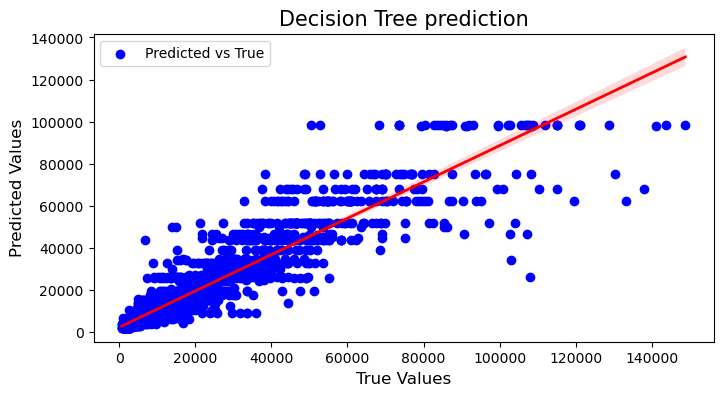

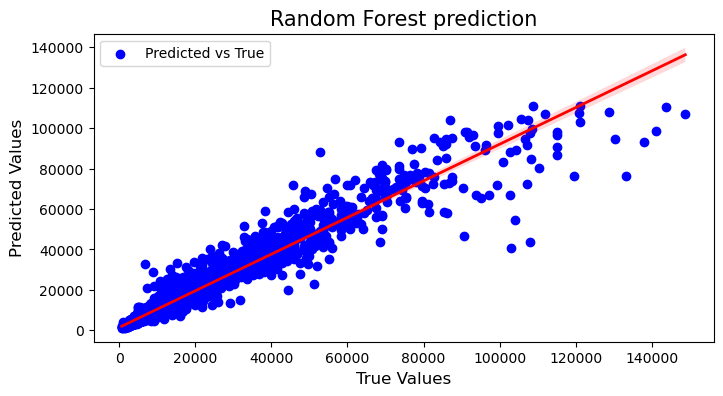

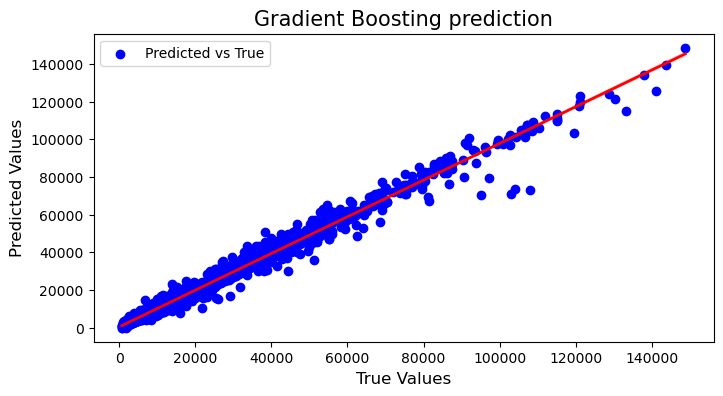

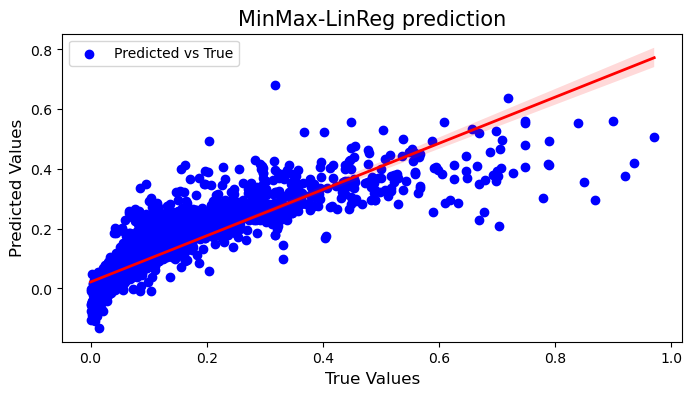

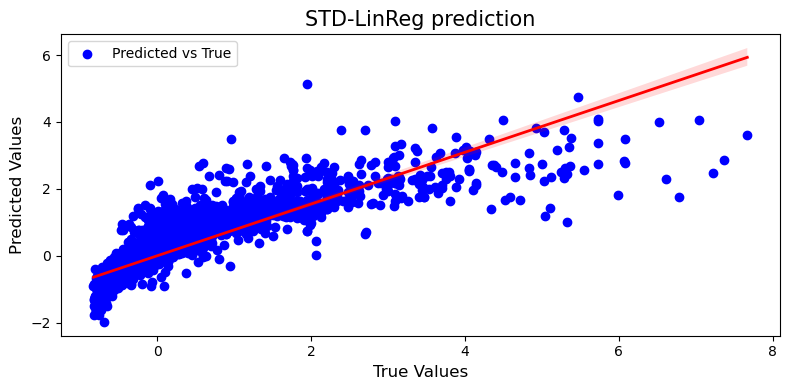

In [70]:
for i in range(5):
    show_the_pred_result(y_true_list_train[i], train_pred[i], mm_scaler, std_scaler, model_names[i], modes[i], 0, 1)

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

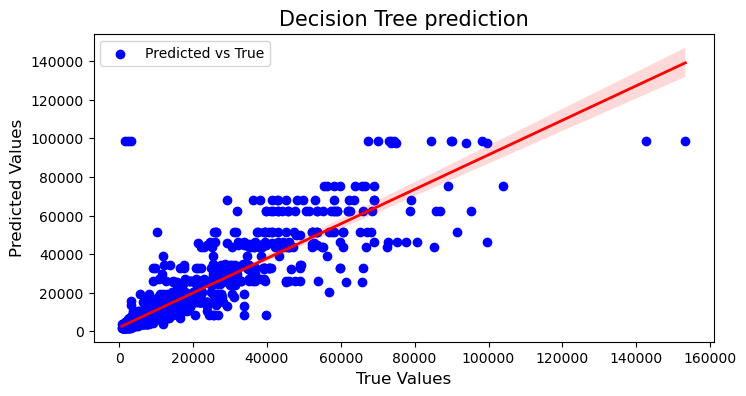

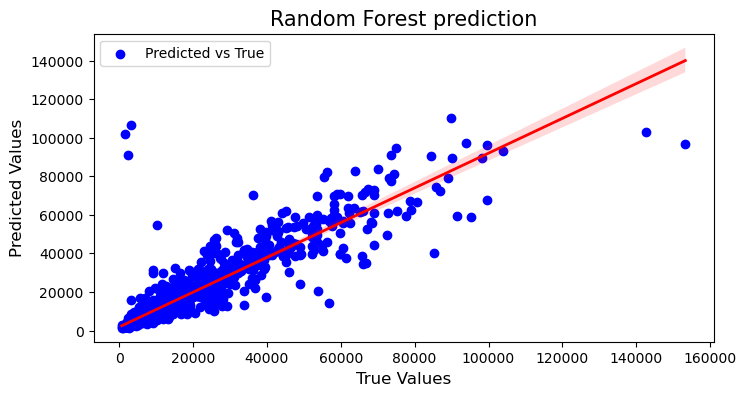

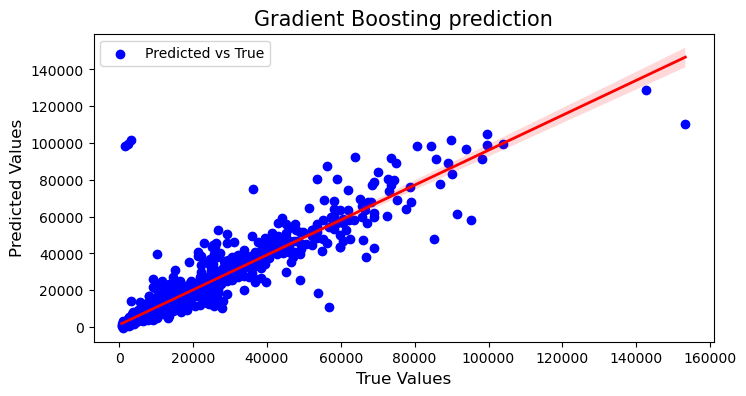

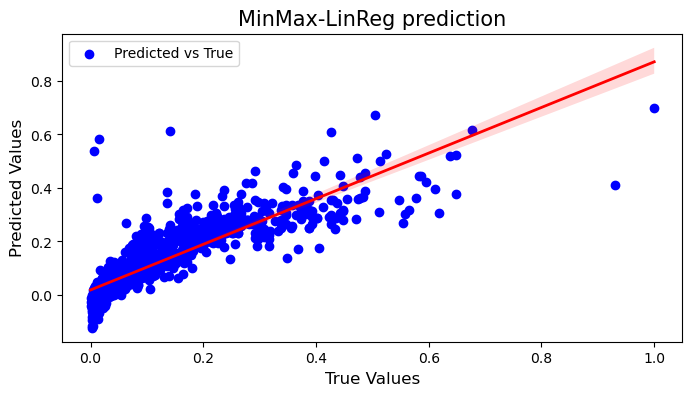

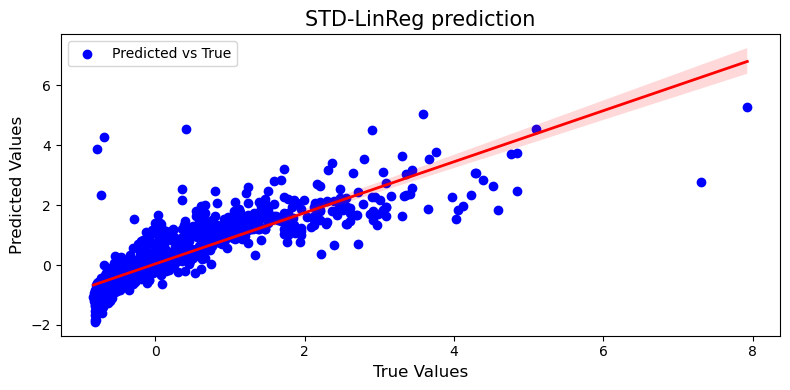

In [71]:
for i in range(5):
    show_the_pred_result(y_true_list_test[i], test_pred[i], mm_scaler, std_scaler, model_names[i], modes[i], 0, 1)

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

# 7. 모델 분석 및 변수 중요도 추출

### LinReg OLS를 사용한 변수 중요도 및 검정 -> 결과값이 달라서 사용 불가

In [72]:
# formula 텍스트 만드는 함수

def make_formula_txt(column_list, y_value):
    y_index = column_list.index(y_value)
    formula_text = column_list[y_index] + " ~ "
    x_list = column_list.copy()
    x_list.remove(y_value)
    #print(x_list)
    for i in range(1, len(x_list)):
        formula_text += x_list[i] + "+"
    formula_text = formula_text[:-1]
    formula_text
    
    return formula_text

    # formula 텍스트 만드는 함수

def make_formula_txt_c(column_list, y_value, object_x):
    y_index = column_list.index(y_value)
    formula_text = column_list[y_index] + " ~ "
    x_list = column_list.copy()
    x_list.remove(y_value)
    #print(x_list)
    
    for i in range(0, len(x_list)):
        if x_list[i] in object_x:
            #print(x_list[i])
            formula_text += "C(" + x_list[i] + ")+"
        else:
            formula_text += x_list[i] + "+"
    formula_text = formula_text[:-1]
    
    return formula_text

In [73]:
# 모델 실행 코드

def run_ols(column_list, y_value, data, object_x):
    if len(object_x) == 0:
        formula_text = make_formula_txt(column_list, y_value)
    else:
        formula_text = make_formula_txt(column_list, y_value, object_x)
    reg_model = smf.ols(formula = formula_text, data = data)
    reg_result = reg_model.fit()
    print(reg_result.summary())
    
    return reg_result

#### one-hot-encoding 적용

In [74]:
for_ols_data = pre_data.copy()
for_ols_data[continue_cols] = pd.DataFrame(np.log1p(for_ols_data[continue_cols]))
for_ols_data = pd.get_dummies(for_ols_data)
for_ols_data.columns = for_ols_data.columns.str.replace("-","_")
for_ols_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   5956 non-null   float64
 1   Kilometers_Driven       5956 non-null   float64
 2   Owner_Type              5956 non-null   int64  
 3   Mileage                 5956 non-null   float64
 4   Power                   5956 non-null   float64
 5   Car_Age                 5956 non-null   int32  
 6   Location_Ahmedabad      5956 non-null   uint8  
 7   Location_Bangalore      5956 non-null   uint8  
 8   Location_Chennai        5956 non-null   uint8  
 9   Location_Coimbatore     5956 non-null   uint8  
 10  Location_Delhi          5956 non-null   uint8  
 11  Location_Hyderabad      5956 non-null   uint8  
 12  Location_Jaipur         5956 non-null   uint8  
 13  Location_Kochi          5956 non-null   uint8  
 14  Location_Kolkata        5956 non-null   

In [78]:
object_x = []
df_train, df_test = train_test_split(for_ols_data, test_size = 0.3, random_state = 661)
run_ols(df_train.columns.tolist(), 'Price', df_train, object_x)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     296.5
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:19:32   Log-Likelihood:                -43839.
No. Observations:                4169   AIC:                         8.776e+04
Df Residuals:                    4126   BIC:                         8.804e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -8137

#### C 적용

In [79]:
for_ols_data_c = pre_data.copy()
for_ols_data_c[continue_cols] = pd.DataFrame(np.log1p(for_ols_data_c[continue_cols]))
object_x = for_ols_data.select_dtypes('object').columns.tolist()
for_ols_data_c.columns = for_ols_data_c.columns.str.replace("-","_")
for_ols_data_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5956 non-null   object 
 1   Price              5956 non-null   float64
 2   Kilometers_Driven  5956 non-null   float64
 3   Fuel_Type          5956 non-null   object 
 4   Transmission       5956 non-null   object 
 5   Owner_Type         5956 non-null   int64  
 6   Mileage            5956 non-null   float64
 7   Power              5956 non-null   float64
 8   Seats_cat          5956 non-null   object 
 9   Brand              5956 non-null   object 
 10  Car_Age            5956 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(5)
memory usage: 488.7+ KB


In [80]:
df_train, df_test = train_test_split(for_ols_data_c, test_size = 0.3, random_state = 661)
run_ols(df_train.columns.tolist(), 'Price', df_train, object_x)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     370.5
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:19:35   Log-Likelihood:                -43871.
No. Observations:                4169   AIC:                         8.781e+04
Df Residuals:                    4135   BIC:                         8.803e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.20

### Log scaling Linear regression 회귀계수를 통한 변수중요도 판별

### Gradient Boosting 변수 중요도 판별

#### 1. 전체 변수에서의 중요도 확인

In [81]:
def find_feature_importance(x_data, model):
    df_importance = pd.DataFrame()
    df_importance["Feature"] = x_data.columns.tolist()
    df_importance["Importance"] = model.feature_importances_
    
    df_importance.sort_values("Importance", ascending=False, inplace = True)
    df_importance.round(3).reset_index(drop=True)
    display(df_importance.head(10))
    
    top_10_importance = df_importance.head(10).reset_index()
    coordinates = range(10)
    plt.barh(y = coordinates, width = top_10_importance["Importance"])
    plt.yticks(coordinates, top_10_importance["Feature"])
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.show()

    return df_importance

In [82]:
import numpy as np

def sum_brand_importance(feature_importances, feature_names):
    # Brand가 포함된 변수명 필터링
    brand_related_features = [name for name in feature_names if 'Brand' in name]
    
    # Brand 관련 변수의 인덱스를 가져옴
    brand_indices = [i for i, name in enumerate(feature_names) if 'Brand' in name]
    
    # Brand 관련 변수의 중요도 합산
    brand_importance_sum = np.sum([feature_importances[i] for i in brand_indices])
    
    return brand_related_features, brand_importance_sum

# 예시 feature_importances와 feature_names
feature_importances = [0.15, 0.05, 0.1, 0.3, 0.4]  # 모델에서 계산된 변수 중요도
feature_names = ['Brand_A', 'Mileage', 'Brand_B', 'Model', 'Brand_C']  # 각 변수 이름

# 함수 실행
brand_features, brand_importance = sum_brand_importance(feature_importances, feature_names)

print("Brand related features:", brand_features)
print("Sum of Brand importance:", brand_importance)


Brand related features: ['Brand_A', 'Brand_B', 'Brand_C']
Sum of Brand importance: 0.65


In [83]:
def filtering_sum_importance(feature_importance, column_list, keyword):
    filtered_index = [i for i, x in enumerate(column_list) if keyword in x]
    importance_sum = np.sum([feature_importance[i] for i in filtered_index])

    return importance_sum

In [90]:
load_best_model = joblib.load("./Gradient Boosting.pkl")

,Feature,Importance
3,Power,0.686018
4,Car_Age,0.182513
2,Mileage,0.039440
0,Kilometers_Driven,0.027468
34,Brand_Land,0.012002
37,Brand_Mercedes-Benz,0.006736
38,Brand_Mini,0.005669
24,Brand_Audi,0.003935
10,Location_Hyderabad,0.003348
45,Brand_Toyota,0.003174


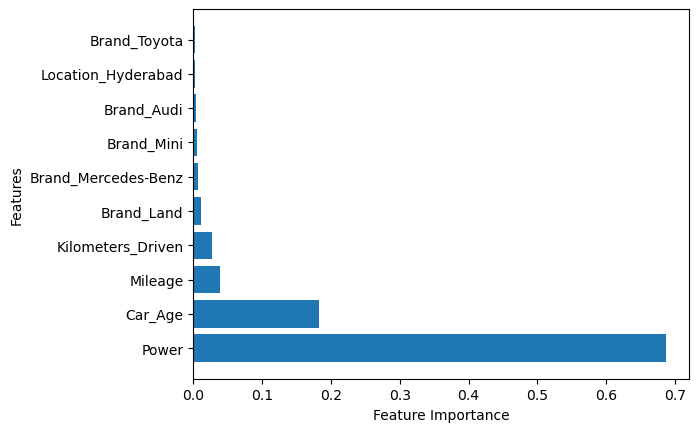

In [91]:
df_importance = find_feature_importance(tree_x_data, load_best_model)

#### 어느지역에서 사업을 시작해야할까?

,Feature,Importance
3,Coimbatore,0.493576
1,Bangalore,0.160696
7,Kochi,0.105463
8,Kolkata,0.076697
6,Jaipur,0.070776
10,Pune,0.055119
2,Chennai,0.034537
0,Ahmedabad,0.003060
5,Hyderabad,0.000028
4,Delhi,0.000027


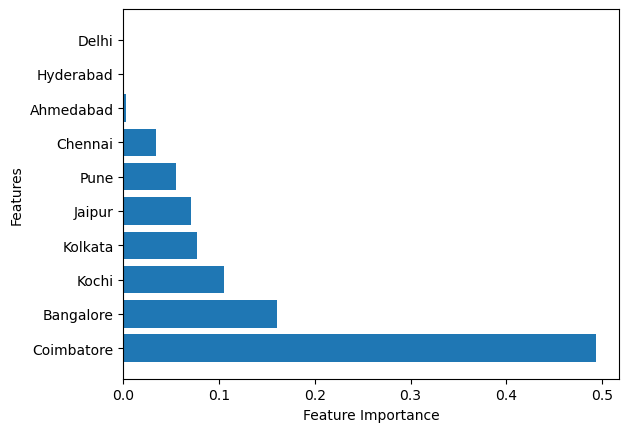

Mumbai        782
Hyderabad     724
Kochi         661
Coimbatore    655
Pune          588
Delhi         551
Kolkata       534
Chennai       478
Jaipur        406
Bangalore     351
Ahmedabad     226
Name: Location, dtype: int64

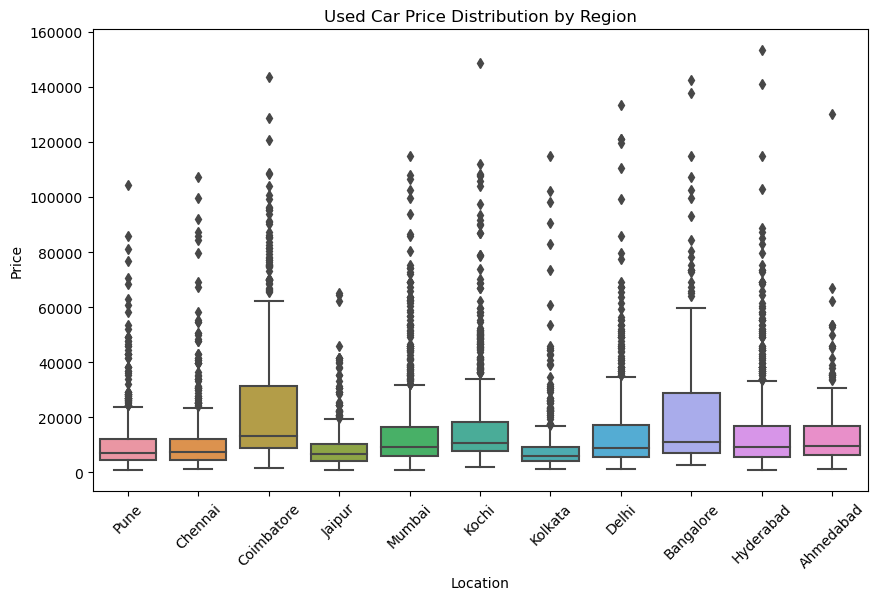

In [92]:
location_x_data = pd.get_dummies(x_data_car['Location'])
location_y_data = y_data_car.copy()

load_best_model.fit(location_x_data, location_y_data)
df_importance_L = find_feature_importance(location_x_data, load_best_model)
display(x_data_car['Location'].value_counts().sort_values(ascending = False))

plt.figure(figsize=(10, 6))
sns.boxplot(x='Location', y='Price', data=pre_data)
plt.title('Used Car Price Distribution by Region')
plt.xticks(rotation = 45)
plt.show()

In [93]:
fi_list = df_importance['Importance'].tolist()
sum_importance_brand = filtering_sum_importance(fi_list, tree_x_data.columns.tolist(),'Location')
print("Location의 총 변수중요도:", sum_importance_brand)

Location의 총 변수중요도: 0.03623423299406934


#### 어떤 브랜드의 차가 가장 좋을까?

,Feature,Importance
13,Mercedes-Benz,0.239776
0,Audi,0.181789
1,BMW,0.179782
10,Land,0.117045
8,Jaguar,0.100159
17,Porsche,0.064634
14,Mini,0.030949
21,Toyota,0.030168
12,Maruti,0.010022
23,Volvo,0.006607


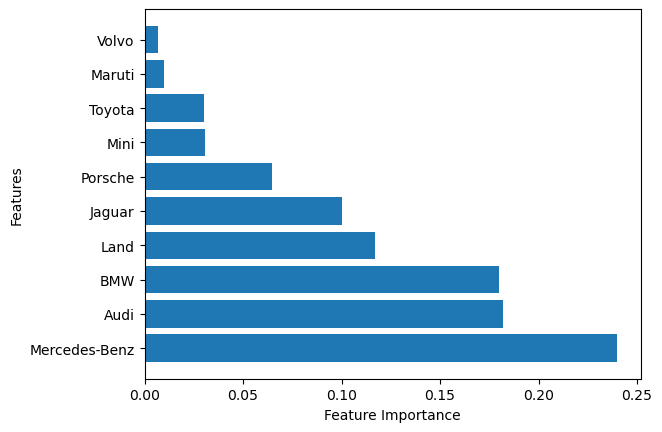

Maruti           1158
Hyundai          1067
Honda             612
Toyota            403
Mercedes-Benz     322
Volkswagen        318
Ford              296
Mahindra          278
BMW               267
Audi              240
Tata              190
Skoda             180
Renault           151
Chevrolet         120
Nissan             93
Land               56
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
Name: Brand, dtype: int64

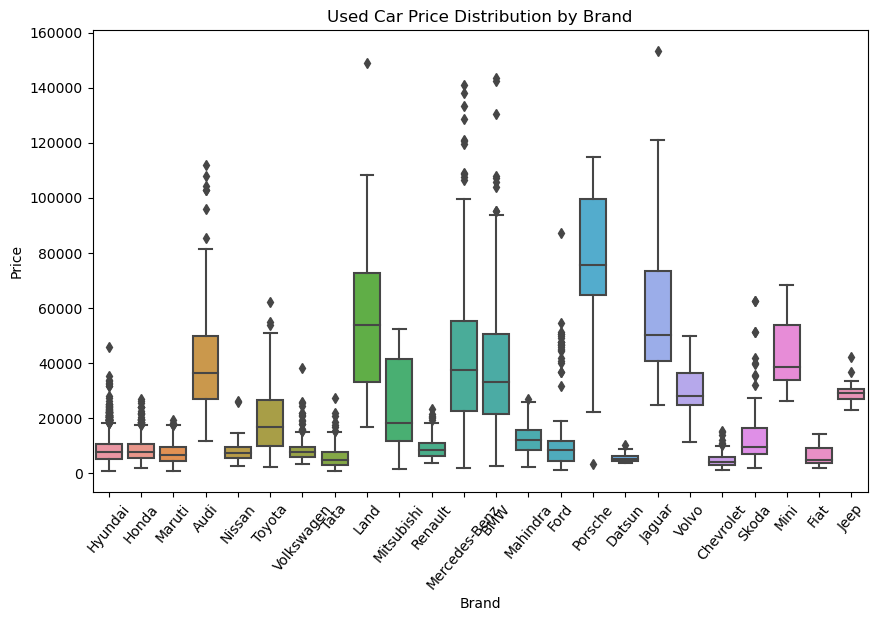

In [94]:
brand_x_data = pd.get_dummies(x_data_car['Brand'])
brand_y_data = y_data_car.copy()

load_best_model.fit(brand_x_data, brand_y_data)
df_importance_B = find_feature_importance(brand_x_data, load_best_model)
display(x_data_car['Brand'].value_counts().sort_values(ascending = False))

plt.figure(figsize=(10, 6))
sns.boxplot(x='Brand', y='Price', data=pre_data)
plt.title('Used Car Price Distribution by Brand')
plt.xticks(rotation = 50)
plt.show()

In [95]:
fi_list = df_importance['Importance'].tolist()
sum_importance_brand = filtering_sum_importance(fi_list, tree_x_data.columns.tolist(),'Brand')
print("Brand의 총 변수중요도:", sum_importance_brand)

Brand의 총 변수중요도: 0.006701052313085185
